In [ ]:
# This notebook compares the Mean/Variance estimate when using
# the control variate technique used within DAIS when compared 
# to standard (vanilla) Monte Carlo.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pylab as plt

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# create target distribution
dim = 10

Sigma_0 = np.eye(dim)
Sigma_1 = 0.9*np.ones((dim,dim))
np.fill_diagonal(Sigma_1, 1.)

mu_0 = 0.*np.ones(dim)
mu_1 = 1.*np.ones(dim)

# @jax.jit
# def log_target_density(z):
#     z_centred = z - mu_1
#     return -0.5 * (jnp.dot(z_centred, jnp.linalg.solve(Sigma_1, z_centred))) 

L_0 = np.linalg.cholesky(Sigma_0)
L_1 = np.linalg.cholesky(Sigma_1)

Inv_0 = np.linalg.inv(Sigma_0)
Inv_1 = np.linalg.inv(Sigma_1)

def log_density(x, mu, Inv):
    return -0.5* np.sum( (x-mu[None,:]) * ((x-mu[None,:]) @ Inv), axis=1)

def grad_log_density(x, mu, Inv):
    return -(x-mu[None,:]) @ Inv.T



In [3]:
# importance sample
S = 10**2
x_samples = np.random.normal(0,1,size=(S,dim))

In [4]:
N = 100
eps_list = 10**np.linspace(-3,0,50)

error_mean_list=[]
error_cov_list=[]
error_mean_list_DAIS=[]
error_cov_list_DAIS=[]


for eps in eps_list:
    error_mean_list_=[]
    error_cov_list_=[]
    error_mean_list_DAIS_=[]
    error_cov_list_DAIS_=[]

    for _ in range(N):
        # create samples
        xi = np.random.normal(0,1,size=(S,dim))        
        x_samples = mu_0[None,:] + xi @ L_0.T

        # compute weights
        LD_target = (1-eps)*log_density(x_samples, mu_0, Inv_0) + eps*log_density(x_samples, mu_1, Inv_1)
        log_weights = LD_target - log_density(x_samples, mu_0, Inv_0)
        log_weights = log_weights - np.max(log_weights)
        weights = np.exp(log_weights)
        weights = weights / np.sum(weights)

        mean_target = np.sum( weights[:,None] * x_samples, axis=0)
        x_samples_centred = x_samples - mean_target[None,:]
        cov_target = x_samples_centred.T @ (weights[:,None] * x_samples_centred)
        
        # DAIS control variate
        grads_0 = grad_log_density(x_samples, mu_0, Inv_0)
        grads_1 = grad_log_density(x_samples, mu_1, Inv_1)
        grads = grads_1 - grads_0
        mean_target_DAIS = mu_0 + eps * Sigma_0 @ np.sum(weights[:,None]* grads,axis=0)
        
        x_samples_centred_DAIS = x_samples - mean_target_DAIS[None,:]
        eps_sigma_grads_centred = eps * (grads @ Sigma_0.T) - (mean_target_DAIS - mu_0)[None,:]
        cov_target_DAIS = Sigma_0 + x_samples_centred_DAIS.T @ (weights[:,None]*eps_sigma_grads_centred)
        cov_target_DAIS = (cov_target_DAIS + cov_target_DAIS.T)/2. 
        
        # True parameters
        mean_target_true = np.linalg.solve((1-eps)*Inv_0 + eps*Inv_1,
                                           (1-eps)*Inv_0 @ mu_0 + eps*Inv_1@mu_1)
        cov_target_true = np.linalg.inv((1-eps)*Inv_0 + eps*Inv_1)

        # errors vanilla IS
        error_mean = np.sum( (mean_target-mean_target_true)**2 )
        error_mean_list_.append( error_mean )
        error_cov = np.sum( (cov_target-cov_target_true)**2 )
        error_cov_list_.append( error_cov )
        
        # errors DAIS
        error_mean = np.sum( (mean_target_DAIS-mean_target_true)**2 )
        error_mean_list_DAIS_.append( error_mean )
        error_cov = np.sum( (cov_target_DAIS-cov_target_true)**2 )
        error_cov_list_DAIS_.append( error_cov )

        

    error_mean_list.append(np.mean(error_mean_list_))
    error_cov_list.append(np.mean(error_cov_list_))

    error_mean_list_DAIS.append(np.mean(error_mean_list_DAIS_))
    error_cov_list_DAIS.append(np.mean(error_cov_list_DAIS_))





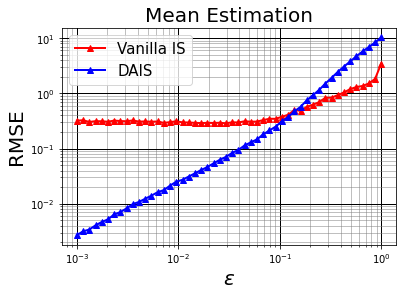

In [5]:
plt.plot(eps_list, np.sqrt(error_mean_list), "r-^", lw=2, label="Vanilla IS")
plt.plot(eps_list, np.sqrt(error_mean_list_DAIS), "b-^", lw=2, label="DAIS")
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="major", color="black", lw=1)
plt.grid(True, which="minor", color="grey", lw=0.5)
plt.title("Mean Estimation", fontsize=20)
plt.xlabel(r"$\epsilon$", fontsize=20)
plt.ylabel(r"RMSE", fontsize=20)
plt.legend(fontsize=15)

plt.savefig("gauss_cv_mean.pdf", dpi=200)



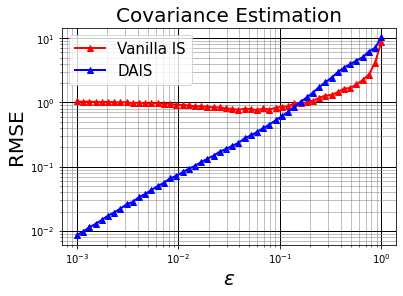

In [6]:
plt.plot(eps_list, np.sqrt(error_cov_list), "r-^", lw=2, label="Vanilla IS")
plt.plot(eps_list, np.sqrt(error_cov_list_DAIS), "b-^", lw=2, label="DAIS")
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="major", color="black", lw=1)
plt.grid(True, which="minor", color="grey", lw=0.5)
plt.title("Covariance Estimation", fontsize=20)
plt.xlabel(r"$\epsilon$", fontsize=20)
plt.ylabel(r"RMSE", fontsize=20)
plt.legend(fontsize=15)


plt.savefig("gauss_cv_cov.pdf", dpi=200)



